# Analysis of Cookie Cats Game

### Objective : 
#### There are two versions - gate_30 and gate_40. We will look into analysing the effects of these two versions on retention of users in 1 day and 7 day time period. 

In [1]:
#Importing modules 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics as stat

#set seaborn as default
sns.set()

In [2]:
#Loading CSV File
cookie_cats = pd.read_csv("cookie_cats.csv")

In [3]:
#Displaying first 10 rows
cookie_cats.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [4]:
#Data set summarization 
cookie_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.9+ MB


<b>Exploratory Data Analysis</b>

In [5]:
cookie_cats.groupby('version', as_index = False).count()

,version,userid,sum_gamerounds,retention_1,retention_7
0,gate_30,44700,44700,44700,44700
1,gate_40,45489,45489,45489,45489


The rows are almost equal for each version which would result in unbiased comparison between the two versions

In [6]:
print("""Row counts:""",cookie_cats['userid'].count(),
      """   Unique counts of users:""",cookie_cats['userid'].nunique())

Row counts: 90189    Unique counts of users: 90189


Therefore, the dataset contains only one row per each user id 

In [7]:
print('Min gameround:',cookie_cats['sum_gamerounds'].min(),
      '  Max gameround:',cookie_cats['sum_gamerounds'].max(),
      '  Unique gameround values:',cookie_cats['sum_gamerounds'].nunique())

Min gameround: 0   Max gameround: 49854   Unique gameround values: 942


<b> Visualising the distribution of Gamerounds for each user </b>

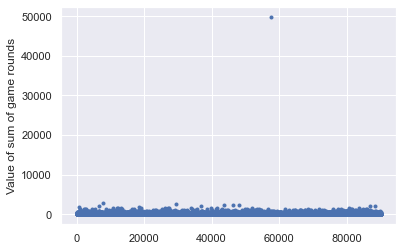

In [8]:
#We have one outlier which correponds to the max gameround value of 49854
plt.plot(cookie_cats['sum_gamerounds'],marker = '.', linestyle = 'none')
plt.ylabel('Value of sum of game rounds')
plt.show()

Taking only the values less than 10000 since all of it lies below that value.

In [9]:
new_gamerounds = cookie_cats[cookie_cats['sum_gamerounds']<10000]['sum_gamerounds']
new_gamerounds = np.array(new_gamerounds) #Converting the series into numpy array

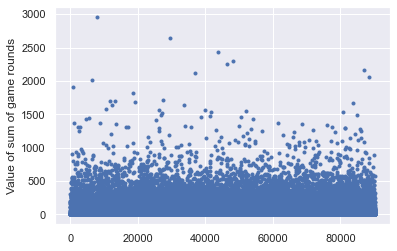

In [10]:
#New distribution after removing outlier 
#This typically does not give much information 
plt.plot(new_gamerounds,marker = '.', linestyle = 'none')
plt.ylabel('Value of sum of game rounds')
plt.show()

In [11]:
#lets plot the ecdf
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

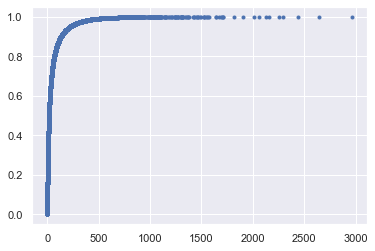

In [12]:
x,y = ecdf(new_gamerounds)
plt.plot(x,y,marker ='.',linestyle = 'none')
plt.show()

Grouping the no of users by sum_gamerounds for better visualization

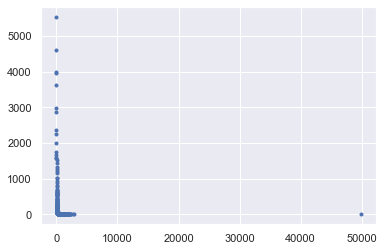

In [13]:
df1 = cookie_cats.groupby('sum_gamerounds', as_index = False)['userid'].nunique()
plt.plot(df1['sum_gamerounds'], df1['userid'],marker = '.',linestyle = 'none')
plt.show()

From the above graph, we still cant really analyse the distribution. Hence limiting to only first few rows. 

In [14]:
df2 = df1[df1['sum_gamerounds']<101]

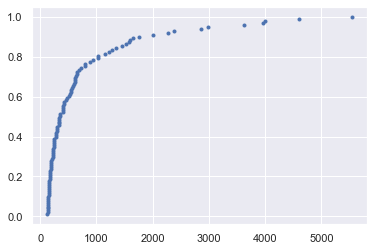

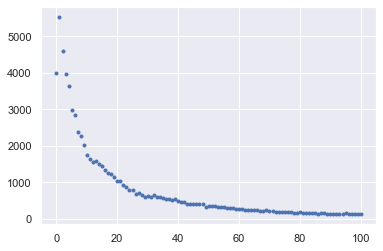

In [15]:
x,y = ecdf(df2['userid'])
plt.plot(x,y,marker ='.',linestyle = 'none')
plt.show()
plt.plot(df2['sum_gamerounds'], df2['userid'],marker = '.',linestyle = 'none')
plt.show()

In [16]:
#Overall 1 day retention of users
print(cookie_cats['retention_1'].sum())
print(cookie_cats[cookie_cats['retention_1']==True]['userid'].nunique())

40153
40153


In [17]:
#1 day retention of users by versions 
print(cookie_cats.groupby('version',as_index = False)['retention_1'].sum())

   version  retention_1
0  gate_30        20034
1  gate_40        20119


In [18]:
#Proportion of retention 
print(cookie_cats.groupby('version',as_index = False)['retention_1'].mean())

   version  retention_1
0  gate_30     0.448188
1  gate_40     0.442283


The level 30 has retention % of 44.8. 

The level 40 has retention % of 44.2.

These values seem close but lets look at it more in-depth by performing statistical analysis -

1. Parameter Estimates for retention % by the two versions 

2. Confidence Intervals for retention % by the two versions

In [19]:
#Creating bootstrap functions 

def bootstrap_replicate(data,func):
    temp = np.random.choice(data,len(data))
    return func(temp)

def bootstrap_sampling(data,func,size):
    bs_replicate = np.empty(size)
    for i in range(size):
        bs_replicate[i] = bootstrap_replicate(data,func)
    return bs_replicate


In [20]:
#Get two datasets - by version 
version_30_1day = cookie_cats[cookie_cats['version'] == 'gate_30']['retention_1'].to_numpy() #converting series to numpy array
version_40_1day = cookie_cats[cookie_cats['version'] == 'gate_40']['retention_1'].to_numpy()
print(len(version_40_1day),len(version_30_1day),len(version_40_1day)+len(version_30_1day),len(cookie_cats))

45489 44700 90189 90189


In [21]:
#Bootstrapping and calculating the mean retention by version         
version_30_1reps= bootstrap_sampling(version_30_1day,np.mean,10000) 
version_40_1reps= bootstrap_sampling(version_40_1day,np.mean,10000) 

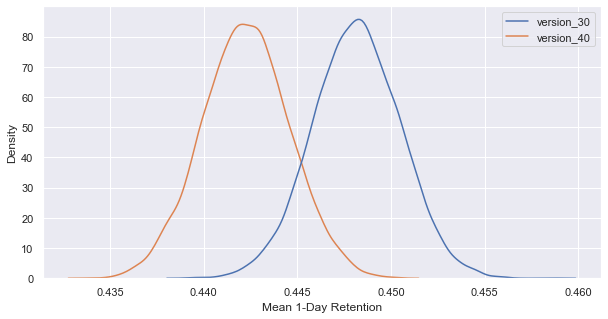

In [22]:
#Coverting the numpy arrays to dataframe
df_bs_versions_1 = pd.DataFrame({'version_30' : version_30_1reps, 'version_40':version_40_1reps},\
                                columns = ['version_30','version_40'])
#Plot KD plot 
plt.figure(figsize=(10,5)) 
sns.kdeplot(data=df_bs_versions_1)
plt.xlabel('Mean 1-Day Retention')
plt.show()

In above plot, there is clearly a difference in the retention % between the two versions

In [23]:
#Parameter Estimation 
print('Mean Retention for level 30: ',np.mean(version_30_1reps)*100)
print('Mean Retention for level 40: ',np.mean(version_40_1reps)*100 )

Mean Retention for level 30:  44.816989261744965
Mean Retention for level 40:  44.225121897601625


In [24]:
#95 % Confidence Interval 
print('95% CI of Mean Retention for level 30: ',(np.percentile(version_30_1reps,[2.5,97.5]))*100)
print('95% CI of Mean Retention for level 40: ',(np.percentile(version_40_1reps,[2.5,97.5]))*100)

95% CI of Mean Retention for level 30:  [44.35346756 45.27516779]
95% CI of Mean Retention for level 40:  [43.7666249  44.68992504]


What if this is a random event? Lets check the hypothesis.

Null Hypothesis : There is no significant difference between the retention % of both the levels. 

In [25]:
#Calculating the test statistic 
diff_of_means = np.mean(version_30_1day)-np.mean(version_40_1day)
print('Difference of means from the dataset:', diff_of_means)

Difference of means from the dataset: 0.005905169787341458


Lets test the null hypothesis by simulating a scenario where the retention % for both will be the same.

This is done by permutation sampling and obtaining the test statistic from these permuted replicates. 

In [26]:
def permutation_samples(a,b,func) :
    a_len = len(a)
    ab = np.concatenate([a,b],axis = 0) #join by appending-->axis = 0
    permuted_data = np.random.permutation(ab)
    a_sample = permuted_data[:a_len]
    b_sample = permuted_data[a_len:]
    return func(a_sample),func(b_sample)

def draw_perm_reps(a,b,func,size):
    a_replicates = np.empty(size)
    b_replicates = np.empty(size)
    for i in range(size):
        a_replicates[i],b_replicates[i] = permutation_samples(a,b,func)
    return a_replicates,b_replicates


In [27]:
v30_1day_perm_reps,v40_1day_perm_reps = draw_perm_reps(version_30_1day,version_40_1day,np.mean,10000)

In [28]:
diff_means_perm_reps = v30_1day_perm_reps-v40_1day_perm_reps

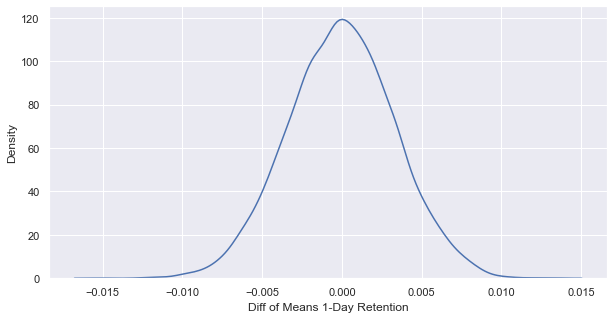

In [29]:
#Plot KD plot 
plt.figure(figsize=(10,5)) 
sns.kdeplot(data=diff_means_perm_reps)
plt.xlabel('Diff of Means 1-Day Retention')
plt.show()

In [30]:
#Calculating the p-value 
print(np.sum(diff_means_perm_reps>=diff_of_means)/10000)

0.0408


Hence, the null hypothesis fails. So there is a significant difference in retention % for the two versions. 

Therefore, retention % of level 30 is better than that of level 40.

<b>Repeating the above steps for 7-day retention</b>

In [31]:
#Get two datasets - by version 
version_30_7day = cookie_cats[cookie_cats['version'] == 'gate_30']['retention_7'].to_numpy() #converting series to numpy array
version_40_7day = cookie_cats[cookie_cats['version'] == 'gate_40']['retention_7'].to_numpy()
print(len(version_40_7day),len(version_30_7day),len(version_40_7day)+len(version_30_7day),len(cookie_cats))

45489 44700 90189 90189


In [32]:
#Bootstrapping and calculating the mean retention by version         
version_30_7reps= bootstrap_sampling(version_30_7day,np.mean,10000) 
version_40_7reps= bootstrap_sampling(version_40_7day,np.mean,10000) 

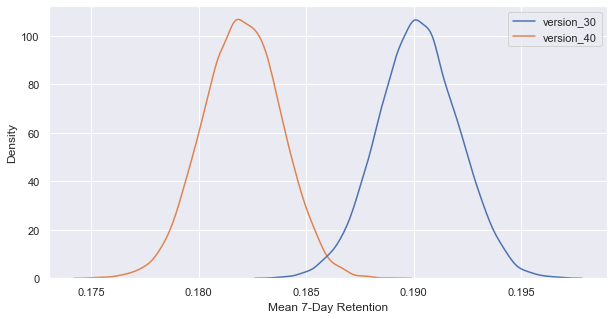

In [33]:
#Coverting the numpy arrays to dataframe
df_bs_versions_7 = pd.DataFrame({'version_30' : version_30_7reps, 'version_40':version_40_7reps},\
                                columns = ['version_30','version_40'])
#Plot KD plot 
plt.figure(figsize=(10,5)) 
sns.kdeplot(data=df_bs_versions_7)
plt.xlabel('Mean 7-Day Retention')
plt.show()

In [34]:
#Parameter Estimation 
print('Mean Retention for level 30: ',np.mean(version_30_7reps)*100)
print('Mean Retention for level 40: ',np.mean(version_40_7reps)*100 )

Mean Retention for level 30:  19.02158590604027
Mean Retention for level 40:  18.200670271933877


In [36]:
#95 % Confidence Interval 
print('95% CI of Mean Retention for level 30: ',(np.percentile(version_30_7reps,[2.5,97.5]))*100)
print('95% CI of Mean Retention for level 40: ',(np.percentile(version_40_7reps,[2.5,97.5]))*100)

95% CI of Mean Retention for level 30:  [18.65100671 19.39149888]
95% CI of Mean Retention for level 40:  [17.84607268 18.54953945]


In [37]:
#Calculating the test statistic 
diff_of_means_7 = np.mean(version_30_7day)-np.mean(version_40_7day)
print('Difference of means from the dataset:', diff_of_means_7)

Difference of means from the dataset: 0.008201298315205913


In [38]:
v30_7day_perm_reps,v40_7day_perm_reps = draw_perm_reps(version_30_7day,version_40_7day,np.mean,10000)

In [39]:
diff_means_perm_reps_7 = v30_7day_perm_reps-v40_7day_perm_reps

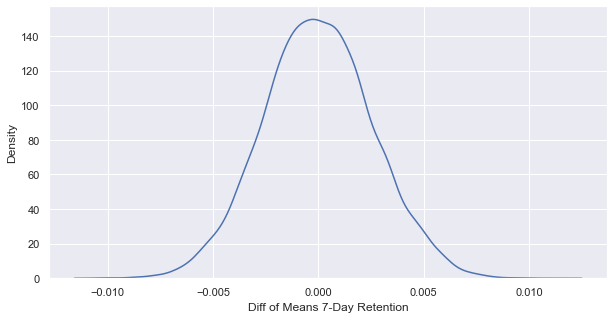

In [40]:
#Plot KD plot 
plt.figure(figsize=(10,5)) 
sns.kdeplot(data=diff_means_perm_reps_7)
plt.xlabel('Diff of Means 7-Day Retention')
plt.show()

In [41]:
#Calculating the p-value 
print(np.sum(diff_means_perm_reps_7>=diff_of_means_7)/10000)

0.0008


Hence, the p value is extremely low. 

Therefore, the null hypothesis fails. 

Level 30 has higher retention rate than level 40. 